# PROJET 8 - Déployez un modèle dans le cloud

## Importations

In [1]:
import os
fruits = ['Apricot', 'Clementine', 'Lychee']
path = "s3a://ocp8fruits//"

Java 8

Spark 3.3.1

Hadoop 3.3

In [2]:
os.getcwd()

'C:\\Users\\pgron\\Jupyter\\P8\\Deployer_un_modele _dans_le_cloud'

In [3]:
print(os.environ['SPARK_HOME'])
print(os.environ['JAVA_HOME'])
print(os.environ['HADOOP_HOME'])

C:\Spark\spark-3.3.1-bin-hadoop3
E:\Documents_pro\anaconda3\Library
C:\Hadoop


In [4]:
import sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import csv
import io
import random

import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.ml.image import ImageSchema
from pyspark import SQLContext
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.sql.functions import lit
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.functions import input_file_name
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, lower, split
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

import keras
import cv2
import PIL
from PIL import Image, ImageOps
import skimage
from skimage import io 
from skimage.io import imshow, imread
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from skimage import img_as_ubyte, img_as_uint
from keras.layers import Dense, Activation, Flatten
from PIL import ImageFilter
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.layers import Dense
from keras import Model
from keras.layers import Flatten
import keras.optimizers

import warnings
warnings.simplefilter(action = 'ignore') 

Sets the environnement variable 'PYSPARK_SUBMIT_ARGS' in order :

   - to fetch the databricks sparkdl package, as soon as the pyspark-submit command will be run
   - to make Hadoop AWS package available when spark will be loaded

## Functions

In [6]:
#Import AWS key
def load_aws_key():
    key = pd.read_csv('rootkey.csv', sep = ';').set_index('KEY')
    ID = key.loc['AWSAccessKeyId'][0]
    KEY = key.loc['AWSSecretKey'][0]
    os.environ["AWS_ACCESS_KEY_ID"] = ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = KEY
    
    return ID, KEY


access_ID, access_KEY = load_aws_key()

In [7]:
#Split path with '/'
def parse_categorie(path):
    if len(path) > 0:
        return path.split('/')[-2]
    else:
        return ''

In [8]:
# Create image df    
def load_data(path):
    start = time.time()
    df_img = spark.read.format("Image").load(path)
    df_img = df_img.withColumn("Path", input_file_name())
    udf_categorie = udf(parse_categorie, StringType())
    df_img = df_img.withColumn('Category', udf_categorie('Path'))
#     print('Loading time : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    
    return df_img

## Create a Spark DataFrame containing the pictures

In [10]:
conf = SparkConf()
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.3')
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.3')
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-client:3.2.3')
conf.setAppName('P8_app')
conf.setMaster('local')

spark = SparkSession.builder\
    .config(conf = conf)\
    .getOrCreate()
spark

In [11]:
sc = spark.sparkContext

hadoop_conf = sc._jsc.hadoopConfiguration()

hadoop_conf.set("fs.s3a.path.style.access", "true")
hadoop_conf.set('fs.s3a.endpoint', 'S3.eu-west-1.amazonaws.com')
hadoop_conf.set("fs.s3a.access.key", access_ID)
hadoop_conf.set("fs.s3a.secret.key", access_KEY)
hadoop_conf.set("fs.s3a.aws.credentials.provider","com.amazonaws.auth.profile.ProfileCredentialsProvider")
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set('com.amazonaws.services.s3a.enableV4', 'true')

In [12]:
for fruit in fruits :
    path_fruit = path + "{}".format(fruit)
    fruit_df = load_data(path = path_fruit)
    if fruit == fruits[0]:
        image_df = fruit_df
    else:
        image_df = image_df.union(fruit_df)
    
    del fruit_df
    
image_df.show()
nb = image_df.count()
print('DF count {} elements.'.format(nb))

Loading time : 03 secondes
Loading time : 00 secondes
Loading time : 00 secondes
+--------------------+--------------------+----------+
|               image|                Path|  Category|
+--------------------+--------------------+----------+
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|   Apricot|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|Clementine|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|Clementine|
|{s3a://ocp8fruits...|s3a://ocp8fruits/...|Clementine|
|{s3a://ocp8fruits...|s3a://ocp8fruits/

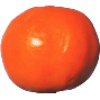

In [13]:
# Show an image
idx = random.randint(0,nb)
a = image_df.collect()[idx]
b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
Image.fromarray(b, 'RGB')

## Features extraction

### VGG16 

In [5]:
# load model without classifier layers
model_extr = VGG16(include_top = False, input_shape = (100, 100, 3))
# add new classifier layers
flat1 = Flatten()(model_extr.layers[-1].output)
output = Dense(1000, activation ='relu')(flat1)
# define new model
model_cnn = Model(inputs = model_extr.inputs, outputs = output)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [15]:
temps1 = time.time()
VGG16_pred = []
nb = image_df.count()

for idx in range (0, nb):
    a = image_df.collect()[idx]
    b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
    img =  b.reshape((1, b.shape[0], b.shape[1], b.shape[2]))
    img_ready = preprocess_input(img)
    pred = model_cnn.predict(img_ready)
    VGG16_pred.append(pred)
    del pred
    
feat_VGG16 = np.asarray(VGG16_pred)
feat_VGG16.shape = (image_df.count(), 1000)

duration1 = time.time() - temps1
print("temps de traitement VGG16 descriptor : ", "%15.2f" % duration1, "secondes")

1/1 [==============================] - 0s 45ms/step
temps de traitement VGG16 descriptor :           119.27 secondes


In [16]:
list_feat = feat_VGG16.tolist()
data = [Vectors.dense(l) for l in list_feat]

a = image_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = spark.createDataFrame([(l,) for l in data], ['Features'])
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

image_feat = a.join(b, a.row_idx == b.row_idx).drop("row_idx")
image_feat = image_feat.drop('image')
image_feat.show()

+--------------------+----------+--------------------+
|                Path|  Category|            Features|
+--------------------+----------+--------------------+
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,6.069554...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,17.5...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,20.0...|
|s3a://ocp8fruits/...|   Apricot|[0.0,4.8060884475...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,12.34049...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,8.115951...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,10.10343...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,10.57868...|
|s3a://ocp8fruits/...|   Apricot|[0.0,1.0488718748...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,18.35713...|
|s3a://ocp8fruits/...|Clementine|[0.0,0.0,0.0,0.0,...|
|s3a://ocp8fruits/...|Clementine|[0.0,5.5707306861...|
|s3a://ocp8fruits/...|Clementine|[0.0,4.7682480812...|
|s3a://ocp8fruits/...|Clementine|[0.0,5.8232831954...|
|s3a://ocp8fruits/...|Clementine|[0.0,8.3801469802...|
|s3a://ocp

## PCA

In [18]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [19]:
# Standardize the features
scaler = StandardScaler(
    inputCol = 'Features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
)

model_sc = scaler.fit(image_feat)
image_feat_sc = model_sc.transform(image_feat)
image_feat_sc.show(20)

+--------------------+----------+--------------------+--------------------+
|                Path|  Category|            Features|      scaledFeatures|
+--------------------+----------+--------------------+--------------------+
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,6.069554...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,17.5...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,20.0...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,4.8060884475...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,12.34049...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,8.115951...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,10.10343...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,10.57868...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,1.0488718748...|[-0.6337590830754...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,18.35713...|[-0.6337590830754...|
|s3a://ocp8f

In [20]:
# PCA with n = 4
pca = PCA(k = 4,
          inputCol = "scaledFeatures",
          outputCol = "pca_features")
# Fit & transform the model on the extracted features
model_pca = pca.fit(image_feat_sc)
image_feat_pca = model_pca.transform(image_feat_sc)
print('Explained Variance Ratio', model_pca.explainedVariance.toArray())
image_feat_pca.show(20)

Explained Variance Ratio [0.284246   0.14900259 0.07884502 0.06986261]
+--------------------+----------+--------------------+--------------------+--------------------+
|                Path|  Category|            Features|      scaledFeatures|        pca_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,6.069554...|[-0.6337590830754...|[11.0220949304773...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,17.5...|[-0.6337590830754...|[12.9261955260719...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,0.0,20.0...|[-0.6337590830754...|[12.7771296431940...|
|s3a://ocp8fruits/...|   Apricot|[0.0,4.8060884475...|[-0.6337590830754...|[11.8079073072919...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,12.34049...|[-0.6337590830754...|[13.8588177677941...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,8.115951...|[-0.6337590830754...|[13.1357683720682...|
|s3a://ocp8fruits/...|   Apricot|[0.0,0.0,10.10343...|[-

In [ ]:
df_final = image_feat_pca.drop(['Path', 'Features', 'scaledFeatures'])

In [24]:
df_final.write.mode('overwrite').parquet(path + "pca//df_final.parquet")

In [12]:
df = spark.read.parquet(path + 'pca//df_final.parquet')
df.show()

+----------+--------------------+
|  Category|        pca_features|
+----------+--------------------+
|   Apricot|[-11.234705833537...|
|   Apricot|[-14.359796692309...|
|   Apricot|[-14.272371504297...|
|   Apricot|[-11.179062976268...|
|   Apricot|[-13.359659179762...|
|   Apricot|[-12.022343380215...|
|   Apricot|[-10.277471926676...|
|   Apricot|[-14.019620913256...|
|   Apricot|[-10.915508792194...|
|   Apricot|[-14.398429453119...|
|Clementine|[-8.9714173901458...|
|Clementine|[-8.6192872367839...|
|Clementine|[-9.9996490190683...|
|Clementine|[-8.2325440375028...|
|Clementine|[-8.6972548638117...|
|Clementine|[-8.6461413882152...|
|Clementine|[-9.0464636109169...|
|Clementine|[-10.212175125150...|
|    Lychee|[28.2389351506612...|
|    Lychee|[26.9606819525806...|
+----------+--------------------+
only showing top 20 rows

